## Visualizing the dataset

In [1]:
import pyphysics as phys
import uproot
import awkward as ak
import hist
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### What should we expect from the energy-loss profile on gas?


In [2]:
parts = ["p", "d", "t"]
data = ak.concatenate([
    ak.with_field(uproot.open("./Outputs/tree_11Li_2H_1H_Ex_0.00.root:SimulationTree").arrays(), "p", "label"),
    ak.with_field(uproot.open("./Outputs/tree_11Li_2H_2H_Ex_0.00.root:SimulationTree").arrays(), "d", "label"),
    ak.with_field(uproot.open("./Outputs/tree_11Li_2H_3H_Ex_0.00.root:SimulationTree").arrays(), "t", "label"),
])

In [3]:
## Kinematics plot
hkins = {}
for part in parts:
    hkin = hist.Hist.new.Reg(300, 0, 80, label="theta [deg]").Reg(300, 0, 80, label="Elab [MeV]").Double()
    gated = data[data.label == part]
    hkin.fill(gated.theta3, gated.T3)
    hkins[part] = hkin


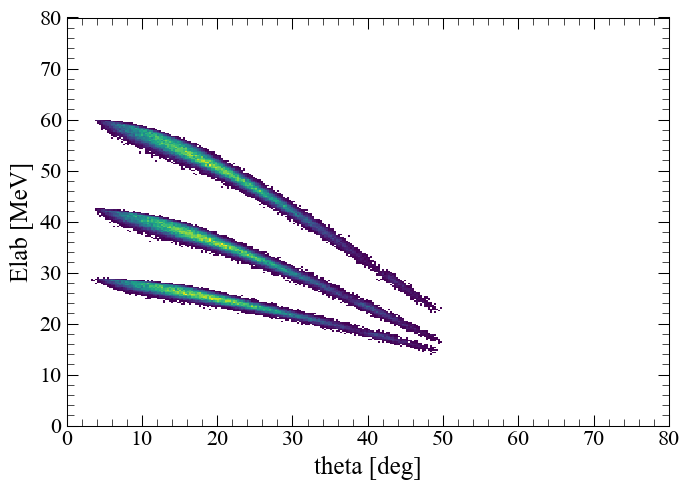

In [4]:
fig, ax = plt.subplots(1, 1)
for i, p in enumerate(parts):
    hkins[p].plot(ax=ax, cmin=1, cbar=None)
fig.tight_layout()

In [5]:
## Gate on events with same initial conditions
Tini = 25
theta3 = 40
RPx = 220
offset = 5

gate = (
    (data.T3 >= Tini - offset) & (data.T3 <= Tini + offset) &
    (data.theta3 >= theta3 - offset) & (data.theta3 <= theta3 + offset) &
    (data.RPx >= RPx - offset) & (data.RPx <= RPx + offset)
)

gated = data[gate]

counts = np.unique(gated.label, return_counts=True)
counts

<Array [['d', 'p', 't'], [283, ..., 2]] type='2 * var * union[string, int64]'>

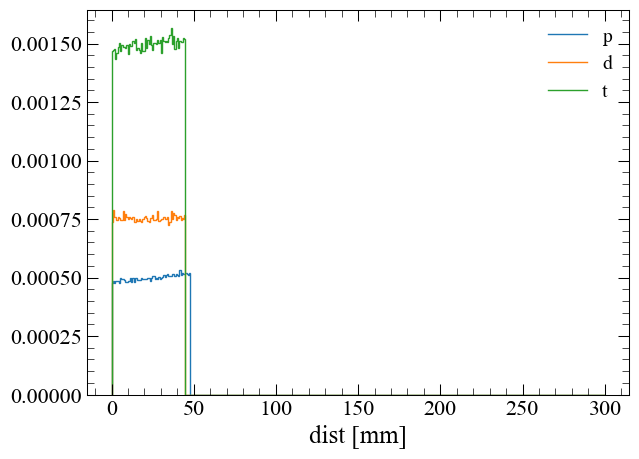

In [6]:
fig, ax = plt.subplots(1, 1)
for p in ["p", "d", "t"]:
    if not len(gated[gated.label == p]):
        continue
    proj = gated[gated.label == p][1].profy
    h = hist.Hist.new.Reg(400, 0, 300, label="dist [mm]").Double()
    h[...] = proj
    h.plot(histtype="step", yerr=False,label=p)
ax.legend()

Let's simulate energy profiles for the different particles

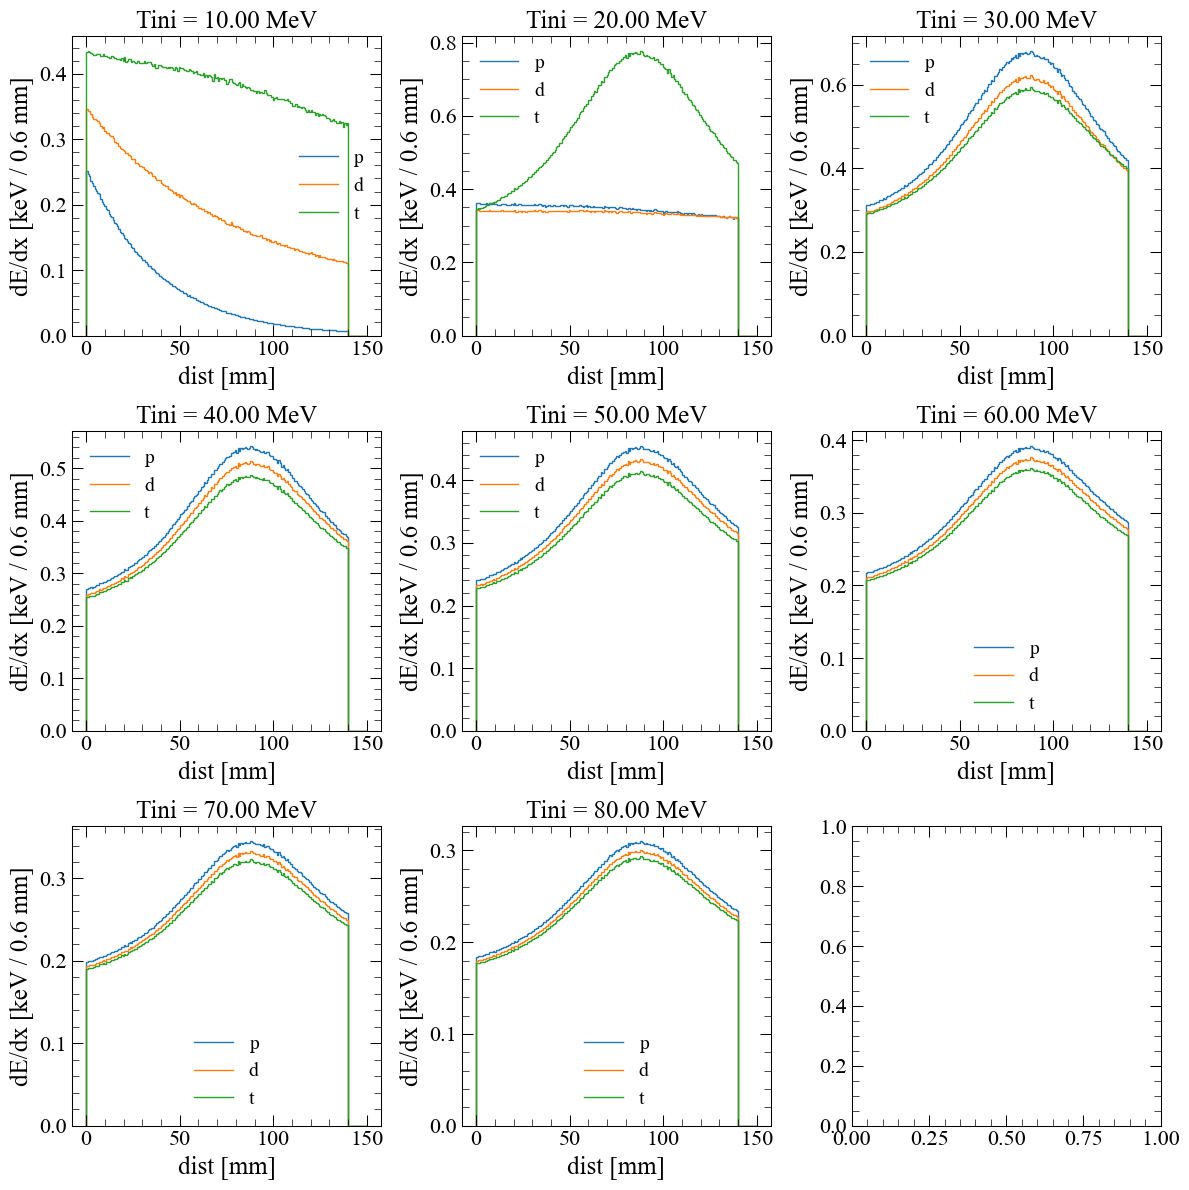

In [14]:
def build_profile(el: phys.EnergyLoss, key: str, Tini: float, dist: float, h: hist.BaseHist):
    niter = 10
    nstep = 1000
    dx = dist / nstep
    for _ in range(niter):
        Taux = Tini
        for i in range(nstep):
            Tafter = el.slow(key, Taux, dx)
            deltaE = (Taux - Tafter) * 1e3
            deltaE = np.random.normal(deltaE, deltaE * 0.05)
            Taux = Tafter
            h.fill(dx * i, sample=[deltaE])

h = hist.Hist.new.Reg(200, 0, 150, label="dist [mm]").Mean()

el = phys.EnergyLoss()
el.read("p", "./Inputs/SRIM/1H_900mb_CF4_90-10.txt")
el.read("d", "./Inputs/SRIM/2H_900mb_CF4_90-10.txt")
el.read("t", "./Inputs/SRIM/3H_900mb_CF4_90-10.txt")
# el.read("11Li", "./Inputs/SRIM/11Li_900mb_CF4_90-10.txt")

dist = 140
energies = np.arange(10, 90, 10)
n = int(np.ceil(np.sqrt(len(energies))))
fig, axs = plt.subplots(n, n, figsize=(4*n, 4*n))
for i, e in enumerate(energies):
    ax = axs.flat[i]
    hit = h.copy()
    hit.reset()
    for p in el.keys:
        build_profile(el, p, e, dist, h)
        h.plot(ax=ax, histtype="step", yerr=False, label=p)
    ax.set_title(f"Tini = {e:.2f} MeV")
    ax.set_ylabel("dE/dx [keV / 0.6 mm]")
    ax.legend()
fig.tight_layout()

# hs = [h.copy() for i in range(len(el.keys))]

# Tini =  30
# dist = 110
# for i, p in enumerate(el.keys):
#     build_profile(el, p, Tini, dist, hs[i])
#     hs[i].plot(histtype="step", yerr=False, label=p)
# plt.ylabel("dE/dx [keV / 0.6 mm]")
# plt.legend()

